## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_ta as ta
import os

from utils import *

## Importing Data

In [2]:
ticker = 'AAPL'
today = pd.Timestamp.now().strftime("%Y-%m-%d")

if not os.path.exists(f'{ticker}_{today}.csv'):
    df = get_data(ticker, interval='1d', period='10y')
    df.to_csv(f'{ticker}_{today}.csv')
else:
    df = pd.read_csv(f'{ticker}_{today}.csv')
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

[*********************100%***********************]  1 of 1 completed


In [3]:
df.head()

,Close,High,Low,Open,Volume
Date,,,,,
2015-03-30,28.221922,28.228621,27.692635,27.703802,188398800
2015-03-31,27.788662,28.248716,27.773029,28.159385,168362400
2015-04-01,27.748468,27.942764,27.491641,27.875765,162485600
2015-04-02,27.987425,28.041023,27.735065,27.922660,128880400
2015-04-06,28.440781,28.476514,27.766332,27.797598,148776000


## Price Chart

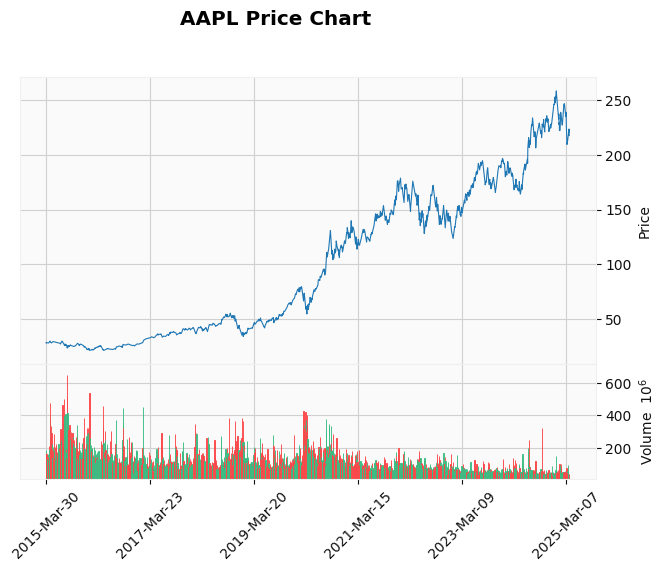

In [4]:
price_chart(df, title=f'{ticker} Price Chart')

## Generating Technical Indicators

In [5]:
df.ta.rsi(length=14, append=True) 
df.ta.ema(length=20, append=True)
df.ta.ema(length=50, append=True)
df.ta.ema(length=200, append=True) 



# drop rows with NaN values because of shift in EMA calculation
df.dropna(inplace=True)

# we determined from feature importance on random forest that Open, High, Low are not important
df.drop(columns=['Open', 'High', 'Low'], inplace=True) 

df.tail()

,Close,Volume,RSI_14,EMA_20,EMA_50,EMA_200
Date,,,,,,
2025-03-24,220.729996,44299500,43.322722,223.876653,230.325294,224.043920
2025-03-25,223.750000,34493600,47.182569,223.864591,230.067439,224.040995
2025-03-26,221.529999,34466100,44.768952,223.642249,229.732638,224.016010
2025-03-27,223.850006,37094800,47.775590,223.662035,229.501946,224.014359
2025-03-28,217.899994,39784100,41.531256,223.113269,229.046968,223.953519


## Defining entry points

In [6]:
df['buy'] = (
    (df['RSI_14'] < 45) &  
    (df['EMA_20'] >= 0.98 * df['EMA_50']) &  
    (df['Close'] >= 0.95 * df['EMA_200'])
).astype(int)


df['buy'].value_counts()

buy
0    1972
1     345
Name: count, dtype: int64

<Axes: >

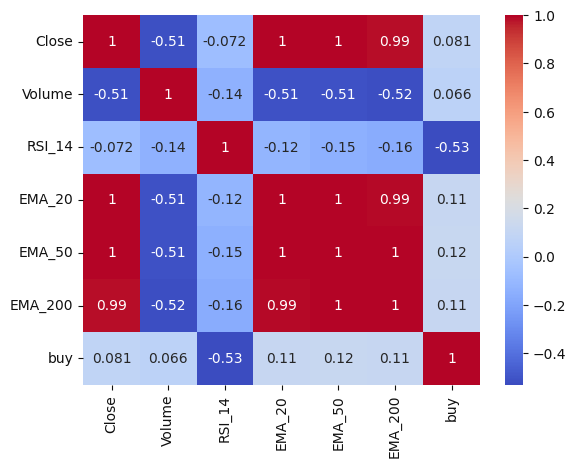

In [7]:
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')

## Classifying the data

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

### Data splitting

In [9]:
train_pct = 0.8
train_size = int(train_pct * len(df))
train = df.iloc[:train_size]
test = df.iloc[train_size:]

X_train = train.drop(columns=['buy'])
y_train = train['buy']

X_test = test.drop(columns=['buy'])
y_test = test['buy']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Random Forest training

In [10]:
classifier_RR = RandomForestClassifier(n_estimators=50, random_state=42)
classifier_RR.fit(X_train_scaled, y_train)

RandomForestClassifier(n_estimators=50, random_state=42)

### Model evaluation

In [11]:
y_pred_RR = classifier_RR.predict(X_test_scaled)

print(classification_report(y_test, y_pred_RR))

              precision    recall  f1-score   support

           0       0.99      0.90      0.94       363
           1       0.72      0.98      0.83       101

    accuracy                           0.91       464
   macro avg       0.86      0.94      0.89       464
weighted avg       0.93      0.91      0.92       464



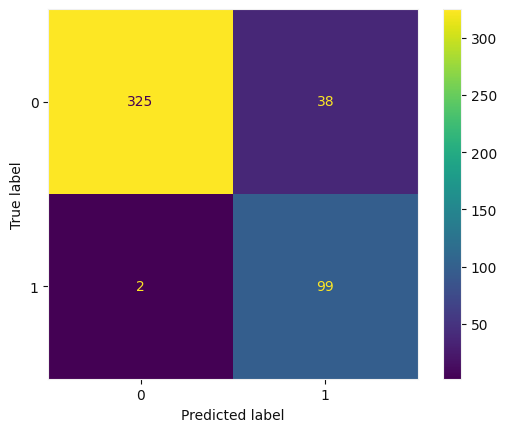

In [12]:
cm = confusion_matrix(y_test, y_pred_RR)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

### features importance

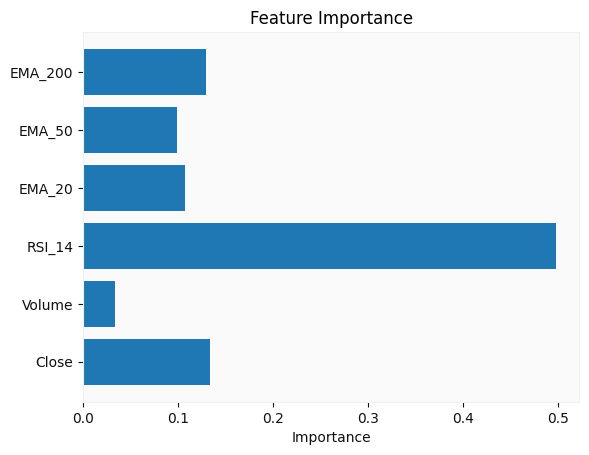

In [13]:
plt.barh(X_train.columns, classifier_RR.feature_importances_)
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

### SVM and KNN training

In [14]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1, 'scale'], 
    'kernel': ['rbf']
}


svm = SVC(class_weight='balanced', random_state=42)


grid_search = GridSearchCV(svm, param_grid, 
                           scoring=['f1', 'accuracy'],
                           n_jobs=-1, refit='f1')
grid_search.fit(X_train_scaled, y_train)


print('param:', grid_search.best_params_)
print('f1:', grid_search.best_score_)


best_svm = grid_search.best_estimator_


y_pred_svm = best_svm.predict(X_test_scaled)
print('SVM Classification Report:\n', classification_report(y_test, y_pred_svm))
confusion_matrix(y_test, y_pred_svm)

param: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
f1: 0.7167881609307283
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.93      0.91       363
           1       0.72      0.61      0.66       101

    accuracy                           0.86       464
   macro avg       0.81      0.77      0.79       464
weighted avg       0.86      0.86      0.86       464



array([[339,  24],
       [ 39,  62]])

In [15]:
param_grid = {
    'n_neighbors': range(1, 21),
    'p': [1, 2]  # Distances --> 1: Manhattan, 2: Euclidean
}


knn = KNeighborsClassifier()


grid_search = GridSearchCV(knn, param_grid,
                           scoring=['f1', 'accuracy'], 
                           n_jobs=-1, refit='f1')
grid_search.fit(X_train_scaled, y_train)


print('params:', grid_search.best_params_)
print('f1:', grid_search.best_score_)


best_knn = grid_search.best_estimator_


y_pred_knn = best_knn.predict(X_test_scaled)
print('KNN Classification Report:\n', classification_report(y_test, y_pred_knn))
confusion_matrix(y_test, y_pred_knn)

params: {'n_neighbors': 3, 'p': 2}
f1: 0.4931825612036199
KNN Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.90      0.93       363
           1       0.71      0.89      0.79       101

    accuracy                           0.90       464
   macro avg       0.84      0.90      0.86       464
weighted avg       0.91      0.90      0.90       464



array([[327,  36],
       [ 11,  90]])